## Holonomic RRT

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as Axes3D
import math
import os


%matplotlib notebook
#NOTE: For interactive graph, run cells one by one. Kernel -> Restart -> Run all will not load plots properly

**We assume fixed yaw to be 0 and have used that in all our formulae**

In [2]:
#function that gives distance between 2 3D points
def distance(a,b,c,x,y,z):
    p1 = np.array([a,b,c])
    p2 = np.array([x,y,z])
    
    return np.linalg.norm(p1-p2, ord=2)

In [3]:
class holonomic_RRT:
    def __init__(self,start_config,goal,obstacles = [[-5, 25, 0, 20, 35, 60],
                                                     [30, 25, 0, 55, 35, 100],
                                                     [45, 35, 0, 55, 60, 60],
                                                     [45, 75, 0, 55, 85, 100],
                                                     [-5, 65, 0, 30, 70, 100],
                                                     [70, 50, 0, 80, 80, 100]]):
        (x0,y0,z0) = start_config
        self.xg = goal[0]
        self.yg = goal[1]
        self.zg = goal[2]
        self.x = []
        self.y = []
        self.z = []
        self.x.append(x0)
        self.y.append(y0)
        self.z.append(z0)
        #add other parameters required
        self.m = 1
        self.g = 10
        self.dt = 1
        self.vx = 0
        self.vy = 0
        self.vz = 0
        self.ax = 0
        self.ay = 0
        self.az = 0
        self.vm = -5
        self.vM = 5
        self.threshold = 0.4
        self.tree_evolution = []
        self.fin_path = []
        self.obstacles = obstacles
    
    #checks for collision with obstacles
    def collision(self,x,y,z,xi,yi,zi):
        obstacles = self.obstacles
        
        xvals = np.linspace(xi,x,20)
        yvals = np.linspace(yi,y,20)
        zvals = np.linspace(zi,z,20)
        for box in obstacles:
            for i in range(xvals.shape[0]):
                if(box[0]<=xvals[i]<=box[3] and box[1]<=yvals[i]<=box[4] and box[2]<=zvals[i]<=box[5]):
                    return True
        return False
    
    
    def acceleration_command(self,theta,phi,T):
        """
        Derive ax,ay,az from theta,phi,T
        """
        self.ax = -math.cos(phi)*math.sin(theta)*T/self.m
        self.ay = math.sin(phi)*T/self.m
        self.az = -self.g + math.cos(phi)*math.cos(theta)*T/self.m        
    
    #updates the velocity given an acceleration
    def vel_update(self):
        vx = self.vx + (self.ax * self.dt)
        vy = self.vy + (self.ay * self.dt)
        vz = self.vz + (self.az * self.dt)
        return vx,vy,vz  
    
    def acceleration_control(self):
        """
        Convert accelerations to position
        """
        vx,vy,vz = self.vel_update()
        
        
        x = self.x[-1] + vx*self.dt
        y = self.y[-1] + vy*self.dt
        z = self.z[-1] + vz*self.dt
        
        return x,y,z
    
    #each node is a point, it stores coordinates, the current input values that took it there and the velocity when it reached
    class Tree:
        def __init__(self, data,v,inputs):
            self.children = []
            self.data = data
            self.v = v
            self.inputs = inputs
    
    #in the tree, it finds the closest node to goal
    def find_closest(self, root, goal, cur_node):
        rg = distance(root.data[0],root.data[1],root.data[2],goal[0],goal[1],goal[2])
        cg = distance(cur_node.data[0],cur_node.data[1],cur_node.data[2],goal[0],goal[1],goal[2])

        if(rg < cg):
            cur_node = root
            
        ret_nodes = []
        for i in range(len(root.children)):
            ret_nodes.append(self.find_closest(root.children[i],goal, cur_node))
        
        for node in ret_nodes:
            cg = distance(cur_node.data[0],cur_node.data[1],cur_node.data[2],goal[0],goal[1],goal[2])
            retg = distance(node.data[0],node.data[1],node.data[2],goal[0],goal[1],goal[2])
            if(retg<cg):
                cur_node = node
        return cur_node
    
    #implement holonomic RRT using tree
    def holonomic_RRT_Tree(self):
        #range of values to check
        phivals = np.linspace(0,2*math.pi,10)
        thetavals = np.linspace(0,2*math.pi,10)
        Tvals = np.linspace(0,10*self.m*self.g,30)
        
        root = self.Tree((self.x[-1],self.y[-1],self.z[-1]),(0,0,0),(0,0,0))
        
        #gets to random goal in greedy fashion, max and min velocity is 5
        for i in range(300):
            #random goal
            goal = np.random.rand(3)*100
            
            #finding closest node to goal
            cur_node = self.find_closest(root, goal, root)
            #getting velocity when it was at that node
            self.vx,self.vy,self.vz = cur_node.v
            
            #stores input values and coordinates that each possible input takes the drone to
            posvals = []
            self.x.append(cur_node.data[0])
            self.y.append(cur_node.data[1])
            self.z.append(cur_node.data[2])
            
            #going through range and checking where they end up
            for phi in phivals:
                for theta in thetavals:
                    for T in Tvals:
                        self.acceleration_command(theta, phi,T)
                        x,y,z = self.acceleration_control()
                        vx,vy,vz = self.vel_update()
                        
                        if(not self.collision(x,y,z,self.x[-1],self.y[-1],self.z[-1]) and self.vm<=vx<=self.vM and self.vm<=vy<=self.vM and self.vm<=vz<=self.vM):
                            posvals.append((x,y,z,theta,phi, T))
            
            #finding the next node to pick, we choose greedily with min distance to goal
            mind = distance(goal[0],goal[1],goal[2],cur_node.data[0],cur_node.data[1],cur_node.data[2])
            minpos = (cur_node.data[0],cur_node.data[1],cur_node.data[2],0,0,0)
            for val in posvals:
                if(mind >= distance(goal[0],goal[1],goal[2],val[0],val[1],val[2])):
                    mind = distance(goal[0],goal[1],goal[2],val[0],val[1],val[2])
                    minpos = val

            #updating acceleration with current chosen input
            self.acceleration_command(minpos[3],minpos[4],minpos[5])
            #updating current velocity, position and adding node to tree
            self.vx,self.vy,self.vz = self.vel_update()
            newnode = self.Tree((minpos[0],minpos[1],minpos[2]),(self.vx,self.vy,self.vz), (minpos[3],minpos[4],minpos[5]))
            cur_node.children.append(newnode)
            self.tree_evolution.append([cur_node.data,newnode.data])
            
        #After expanding the tree we now move on to getting to the actual goal
        while(1):
            #given goal
            goal = np.array([self.xg,self.yg,self.zg])
            #finding closest node to goal
            cur_node = self.find_closest(root, goal, root)
            #getting velocity when it was at that node
            self.vx,self.vy,self.vz = cur_node.v
            
            #stores input values and coordinates that each possible input takes the drone to
            posvals = []
            self.x.append(cur_node.data[0])
            self.y.append(cur_node.data[1])
            self.z.append(cur_node.data[2])
            
            #going through range and checking where they end up
            for phi in phivals:
                for theta in thetavals:
                    for T in Tvals:
                        self.acceleration_command(theta, phi,T)
                        x,y,z = self.acceleration_control()
                        vx,vy,vz = self.vel_update()
                        
                        if(not self.collision(x,y,z,self.x[-1],self.y[-1],self.z[-1]) and self.vm<=vx<=self.vM and self.vm<=vy<=self.vM and self.vm<=vz<=self.vM):
                            posvals.append((x,y,z,theta,phi, T))
            
            #finding the next node to pick, we choose greedily with min distance to goal
            mind = distance(self.xg,self.yg,self.zg,cur_node.data[0],cur_node.data[1],cur_node.data[2])
            minpos = (cur_node.data[0],cur_node.data[1],cur_node.data[2],0,0,0)
            flag = True
            for val in posvals:
                if(mind >= distance(goal[0],goal[1],goal[2],val[0],val[1],val[2])):
                    mind = distance(self.xg,self.yg,self.zg,val[0],val[1],val[2])
                    minpos = val
                    flag = False
            #checks if drone isn't moving
            if(flag):
                break
            #updating acceleration with current chosen input
            self.acceleration_command(minpos[3],minpos[4],minpos[5])
            #updating current velocity, position and adding node to tree
            self.vx,self.vy,self.vz = self.vel_update()
            newnode = self.Tree((minpos[0],minpos[1],minpos[2]),(self.vx,self.vy,self.vz), (minpos[3],minpos[4],minpos[5]))
            cur_node.children.append(newnode)
            self.tree_evolution.append([cur_node.data,newnode.data])
        
        #at the end we do a finer discretization to get closer to the goal
        #this is the same loop as above but with more finer input steps
        phivals = np.linspace(0,2*math.pi,30)
        thetavals = np.linspace(0,2*math.pi,30)
        Tvals = np.linspace(0,10*self.m*self.g,100)
        while(distance(self.xg,self.yg,self.zg,self.x[-1],self.y[-1],self.z[-1])>=self.threshold):
            
            goal = np.array([self.xg,self.yg,self.zg])
            
            cur_node = self.find_closest(root, goal, root)
            self.vx,self.vy,self.vz = cur_node.v
            
            posvals = []
            self.x.append(cur_node.data[0])
            self.y.append(cur_node.data[1])
            self.z.append(cur_node.data[2])
            
            for phi in phivals:
                for theta in thetavals:
                    for T in Tvals:
                        self.acceleration_command(theta, phi,T)
                        x,y,z = self.acceleration_control()
                        vx,vy,vz = self.vel_update()
                        
                        if(not self.collision(x,y,z,self.x[-1],self.y[-1],self.z[-1]) and self.vm<=vx<=self.vM and self.vm<=vy<=self.vM and self.vm<=vz<=self.vM):
                            posvals.append((x,y,z,theta,phi, T))
            
            mind = distance(self.xg,self.yg,self.zg,cur_node.data[0],cur_node.data[1],cur_node.data[2])
            minpos = (cur_node.data[0],cur_node.data[1],cur_node.data[2],0,0,0)
            flag = True
            for val in posvals:
                if(mind >= distance(goal[0],goal[1],goal[2],val[0],val[1],val[2])):
                    mind = distance(self.xg,self.yg,self.zg,val[0],val[1],val[2])
                    minpos = val
                    flag = False
            if(flag):
                break
            self.acceleration_command(minpos[3],minpos[4],minpos[5])
            self.vx,self.vy,self.vz = self.vel_update()
            newnode = self.Tree((minpos[0],minpos[1],minpos[2]),(self.vx,self.vy,self.vz), (minpos[3],minpos[4],minpos[5]))
            cur_node.children.append(newnode)
            self.tree_evolution.append([cur_node.data,newnode.data])
        
        return root
    
    #updates fin_path list to give nodes going start to goal in reverse order
    def find_path(self, root, end):
        if(root==end):
            self.fin_path.append(end)
            return True
        
        for i in range(len(root.children)):
            flag = self.find_path(root.children[i],end)
            if(flag):
                self.fin_path.append(root)
                return True
        return False
        
        
        
    def showpath(self):
        """
        Create a new directory (say nonholonomic_path) and save snapshots of the robot moving along the
        trajectory found by RRT at every step with the step index.
        e.g: snap1.png, snap2.png ...
        """
        obstacles = self.obstacles
        path = self.fin_path
        fig = plt.figure()
        ax = Axes3D.Axes3D(fig)
        for box in obstacles:
            X, Y, Z = hn_RRT.cuboid_data(box)
            ax.plot_surface(X, Y, Z, rstride=1, cstride=1,color=(0.1, 0.15, 0.3, 0.2),zorder = 1)


        for i in range(len(path)-1):
            ch = path[-i-1]
            par = path[-2-i]
            ax.plot([par.data[0],ch.data[0]],[par.data[1],ch.data[1]],[par.data[2],ch.data[2]])
            fig.savefig('RRT_path/snap'+str(i)+'.png')            
        plt.show()
            
        
    def showtree(self):
        """
        Create a new directory (say nonholonomic_tree) and save snapshots of the evolution of the RRT tree
        at every step with the step index.
        e.g: snap1.png, snap2.png ...
        """
        obstacles = self.obstacles
        fig = plt.figure()
        ax = Axes3D.Axes3D(fig)
        for box in obstacles:
            X, Y, Z = self.cuboid_data(box)
            ax.plot_surface(X, Y, Z, rstride=1, cstride=1,color=(0.1, 0.15, 0.3, 0.2),zorder = 1)
        
        for i in range(len(self.tree_evolution)):
            parent = self.tree_evolution[i][0]
            child = self.tree_evolution[i][1]
            ax.plot([parent[0],child[0]],[parent[1],child[1]],[parent[2],child[2]])
            fig.savefig('RRT_tree/snap'+str(i)+'.png')            
        plt.show()
        
    def cuboid_data(self,box):
        l = box[3] - box[0]
        w = box[4] - box[1]
        h = box[5] - box[2]
        x = [[0, l, l, 0, 0],
             [0, l, l, 0, 0],
             [0, l, l, 0, 0],
             [0, l, l, 0, 0]]
        y = [[0, 0, w, w, 0],
             [0, 0, w, w, 0],
             [0, 0, 0, 0, 0],
             [w, w, w, w, w]]
        z = [[0, 0, 0, 0, 0],
             [h, h, h, h, h],
             [0, 0, h, h, 0],
             [0, 0, h, h, 0]]
        return box[0] + np.array(x), box[1] + np.array(y), box[2] + np.array(z)
        
    def test_env(self):
        # 3D boxes   lx, ly, lz, hx, hy, hz
        obstacles = self.obstacles
        
        # create map with obstacles
        fig = plt.figure()
        ax = Axes3D.Axes3D(fig)
        fig.add_axes(ax)
        for box in obstacles:
            X, Y, Z = self.cuboid_data(box)
            ax.plot_surface(X, Y, Z, rstride=1, cstride=1,color=(0.1, 0.15, 0.3, 0.2),zorder = 1)
        plt.show()

# Given Environment

/home/wandra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:330: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


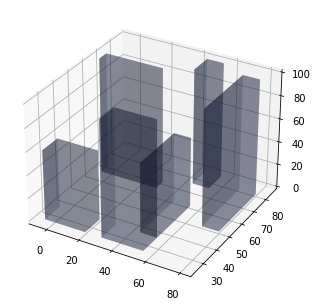

In [6]:
start = (0,1,0)
goal = (100,100,100)
obstacles = [[-5, 25, 0, 20, 35, 60],
             [30, 25, 0, 55, 35, 100],
             [45, 35, 0, 55, 60, 60],
             [45, 75, 0, 55, 85, 100],
             [-5, 65, 0, 30, 70, 100],
             [70, 50, 0, 80, 80, 100]]
hn_RRT = holonomic_RRT(start,goal,obstacles)
hn_RRT.test_env()

In [7]:
root = hn_RRT.holonomic_RRT_Tree()

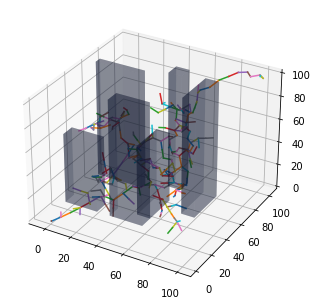

In [9]:
filelist = [ f for f in os.listdir('./RRT_tree') ]
for f in filelist:
    os.remove(os.path.join('./RRT_tree', f))
    
hn_RRT.showtree()

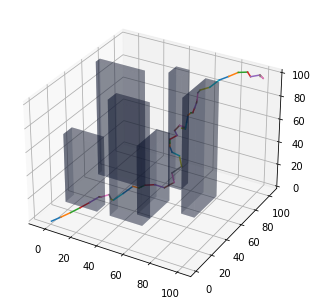

In [10]:
filelist = [ f for f in os.listdir('./RRT_path') ]
for f in filelist:
    os.remove(os.path.join('./RRT_path', f))
    
hn_RRT.fin_path = []
r = hn_RRT.find_closest(root,[100,100,100],root)
hn_RRT.find_path(root,r)
hn_RRT.showpath()

/home/wandra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/wandra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


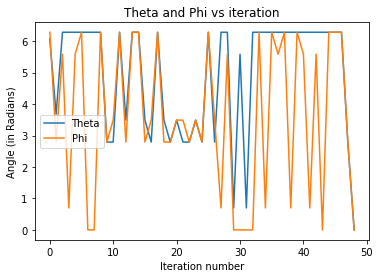

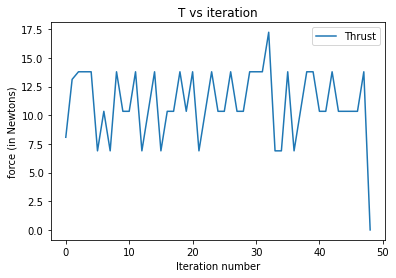

In [12]:
thetavals = []
phivals = []
Tvals = []

for i in range(len(hn_RRT.fin_path)):
    theta,phi,T = hn_RRT.fin_path[i].inputs
    thetavals.append(theta)
    phivals.append(phi)
    Tvals.append(T)
    
f = plt.figure()
plt.plot(thetavals)
plt.plot(phivals)
plt.title('Theta and Phi vs iteration')
plt.xlabel('Iteration number')
plt.ylabel('Angle (in Radians)')
plt.legend(['Theta','Phi'])
f.show()

g = plt.figure()
plt.plot(Tvals)
plt.title('T vs iteration')
plt.xlabel('Iteration number')
plt.ylabel('force (in Newtons)')
plt.legend(['Thrust'])
g.show()

# Custom Environment

/home/wandra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:330: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


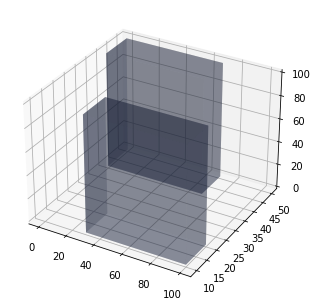

In [18]:
start = (60,-10,40)
goal = (80,60,40)
obstacles = [[30, 10, 0, 100, 20, 100],
             [0, 40, 0, 70, 50, 100]]
hn_RRT = holonomic_RRT(start,goal,obstacles)
hn_RRT.test_env()

In [19]:
root = hn_RRT.holonomic_RRT_Tree()

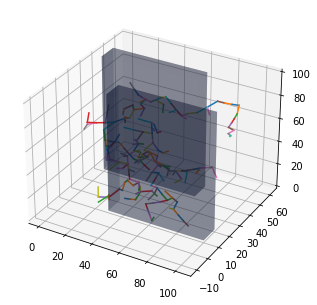

In [20]:
filelist = [ f for f in os.listdir('./RRT_tree') ]
for f in filelist:
    os.remove(os.path.join('./RRT_tree', f))
    
hn_RRT.showtree()

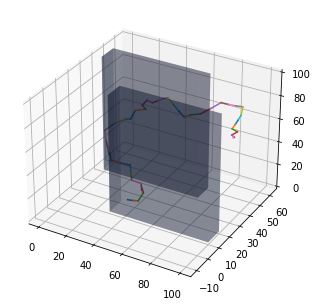

In [21]:
filelist = [ f for f in os.listdir('./RRT_path') ]
for f in filelist:
    os.remove(os.path.join('./RRT_path', f))

hn_RRT.fin_path = []
r = hn_RRT.find_closest(root,[*goal],root)
hn_RRT.find_path(root,r)
hn_RRT.showpath()

/home/wandra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/home/wandra/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


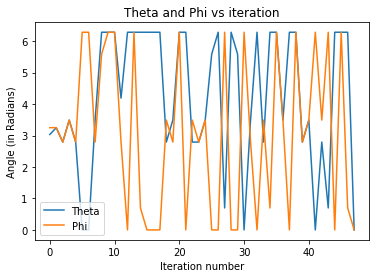

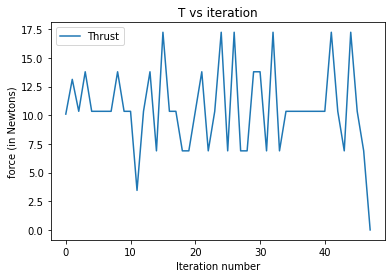

In [22]:
thetavals = []
phivals = []
Tvals = []

for i in range(len(hn_RRT.fin_path)):
    theta,phi,T = hn_RRT.fin_path[i].inputs
    thetavals.append(theta)
    phivals.append(phi)
    Tvals.append(T)
    
f = plt.figure()
plt.plot(thetavals)
plt.plot(phivals)
plt.title('Theta and Phi vs iteration')
plt.xlabel('Iteration number')
plt.ylabel('Angle (in Radians)')
plt.legend(['Theta','Phi'])
f.show()

g = plt.figure()
plt.plot(Tvals)
plt.title('T vs iteration')
plt.xlabel('Iteration number')
plt.ylabel('force (in Newtons)')
plt.legend(['Thrust'])
g.show()